**Name: Trilokinath Modi**

# Basic Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import pandas
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import time
import csv

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import numpy as np
from spacy.lang.en import English

%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

nlp = English()

In [4]:
filePath = "/content/drive/My Drive/MLNLP/FinalAssignment/train.csv"
filePathTest = "/content/drive/My Drive/MLNLP/FinalAssignment/test.csv"
filePathResult = "/content/drive/My Drive/MLNLP/FinalAssignment/"

In [5]:
def readData(fileName):
    # colnames = ['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']
    train_data = pandas.read_csv(fileName)
    X = train_data.text.tolist()
    Y = train_data.is_humor.tolist()
    return X, Y

def readDataTest(fileName):
    test_data = pandas.read_csv(fileName)
    xTest = test_data.text.tolist()
    return xTest  
  
def writeData(fileName, testData, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    headings = ['text', 'is_humor']
    writer = csv.writer(fileHandler)
    writer.writerows(zip(testData, resultList))

def evaluateTest(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    f1score = tp / (tp + 0.5*(fp + fn))
    return accuracy, f1score

# Setup classes used by all methods

The vocabulary class is modified to add 2 special cases used in continuous bag of words approach. The special cases are discussed under the CBOW title. Specifically, the build method is modified.

In [6]:
PAD = '___PAD___'
UNKNOWN = '___UNKNOWN___'

class Vocabulary:
    """Manages the numerical encoding of the vocabulary."""
    
    def __init__(self, tokenizer=None, max_voc_size=None):

        # String-to-integer mapping
        self.stoi = None

        # Integer-to-string mapping
        self.itos = None

        # Tokenizer that will be used to split document strings into words.
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = lambda s: s.split()

        # Maximally allowed vocabulary size.
        self.max_voc_size = max_voc_size
        
    def build(self, docs, position = None, ngrams = None, flagNoStop = None):
        """Builds the vocabulary, based on a set of documents."""
        
        if ngrams == None:
          # Sort all words by frequency
          word_freqs = Counter(w for doc in docs for w in self.tokenizer(doc))
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)
        
        elif flagNoStop == None:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            if int(position[positionIndex]) + ngrams < len(currentDoc) and int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + ngrams + 1):        
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) + ngrams < len(currentDoc):
              for words in range(int(position[positionIndex]), int(position[positionIndex]) + ngrams + 1):
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + 1):
                word_freqs.update([currentDoc[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        elif flagNoStop == 1:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            currentDocNoStop = []
            for iToken in range(len(currentDoc)):
              if not nlp.vocab[currentDoc[iToken]].is_stop and iToken not in ['.', ',', "?"] and not currentDoc[iToken].isdigit() and iToken != int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
              if iToken == int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
                newPosition = len(currentDocNoStop) - 1
            if newPosition + ngrams < len(currentDocNoStop) and newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition + ngrams < len(currentDocNoStop):
              for words in range(newPosition, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + 1):
                word_freqs.update([currentDocNoStop[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        # Build the integer-to-string mapping. The vocabulary starts with the two dummy symbols,
        # and then all words, sorted by frequency. Optionally, limit the vocabulary size.
        if self.max_voc_size:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs[:self.max_voc_size-2] ]
        else:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs ]

        # Build the string-to-integer map by just inverting the aforementioned map.
        self.stoi = { w: i for i, w in enumerate(self.itos) }
        
    def encode(self, docs):
        """Encodes a set of documents."""
        unkn_index = self.stoi[UNKNOWN]
        return [[self.stoi.get(w, unkn_index) for w in self.tokenizer(doc)] for doc in docs]

    def get_unknown_idx(self):
        """Returns the integer index of the special dummy word representing unknown words."""
        return self.stoi[UNKNOWN]
    
    def get_pad_idx(self):
        """Returns the integer index of the special padding dummy word."""
        return self.stoi[PAD]
    
    def __len__(self):
        return len(self.itos)

Class used to store document identities and create batches

In [7]:
class DocumentDataset(Dataset):
    """A Dataset that stores a list of documents and their corresponding category labels."""
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""
    
    def __init__(self, voc):
        # Find the integer index of the dummy padding word.
        self.pad = voc.get_pad_idx()
    
    def __call__(self, XY):
        """Build a batch from a number of documents. Returns two tensors X and Y, where
        X is the document tensor, of shape [n_docs, max_doc_length]

        and 
        
        Y is the label tensor, of shape [n_docs].
        """
        
        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y

Text classifier class which performs the preprocessing, training and prediction for each model. This class is inshort the heart of the program. The class is modified to accomodate changes made in Vocabulary class. Specifically, the preprocess method is modified and simple early stopping criteria is included i.e. the model stops training if for any 3 epochs in previous 5 epochs the validation loss has increased. This early stopping criteria is used for all models.

In [8]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params):
        self.params = params
        self.flagEpoch = 0
        
    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.
        
        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        
        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            scores = self.model(Xbatch)
            loss = self.loss(scores, Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()
            for iY in Ybatch:
              if Ybatch[iY] == 1 and guesses[iY] == Ybatch[iY]:
                TP += 1
              elif Ybatch[iY] == 1:
                FN += 1
              elif Ybatch[iY] == 0 and guesses[iY] == Ybatch[iY]:
                TN += 1
              elif Ybatch[iY] == 0:
                FP += 1
            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss/len(batches), n_correct/n_instances, TP/(TP + 0.5*(FP + FN))
    
    def preprocess(self, X, Y, position = None, ngrams = None, flagNoStop = None):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""

        if ngrams == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain)
        elif flagNoStop == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(np.column_stack((X, position)), Y, test_size=0.2, random_state=0)
          position = Xtrain[:,1]
          Xtrain = list(Xtrain[:,0])
          Xval = list(Xval[:,0])
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain, position, ngrams)
        elif flagNoStop == 1:
          Xtrain, Xval, Ytrain, Yval = train_test_split(np.column_stack((X, position)), Y, test_size=0.2, random_state=0)
          position = Xtrain[:,1]
          Xtrain = list(Xtrain[:,0])
          Xval = list(Xval[:,0])
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain, position, ngrams, flagNoStop)

        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)

        self.voc_size = len(self.voc)
        self.n_classes = len(self.lbl_enc.classes_)
        
        batcher = DocumentBatcher(self.voc)
        
        train_dataset = DocumentDataset(self.voc.encode(Xtrain), self.lbl_enc.transform(Ytrain))
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_dataset = DocumentDataset(self.voc.encode(Xval), self.lbl_enc.transform(Yval))
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.CrossEntropyLoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        epoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            
            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss, train_acc, train_f1_score = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            val_loss, val_acc, val_f1_score = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1_score)
            self.history['val_f1'].append(val_f1_score)
            self.history['time'].append(t1-t0)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, '
                      + f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, time: {t1-t0:.4f}')

            flagEpochArray = np.zeros(5, dtype = int)
            if epoch > 6:
              for iEpoch in range(1,6):
                if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
                  flagEpochArray[iEpoch - 1] = 1
            if np.sum(flagEpochArray) >= 4:
              self.flagEpoch = 1
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.voc)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [self.lbl_enc.classes_[0] for x in X]        
        dataset = DocumentDataset(self.voc.encode(X), self.lbl_enc.transform(dummy_labels))
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        for Xbatch, Ybatch in loader:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            scores = self.model(Xbatch)
            guesses = scores.argmax(dim=1)
            output.extend(self.lbl_enc.inverse_transform(guesses.cpu().numpy()))
        return output

# Training Model CBOW

Class that provides the embedded input tensor.

In [9]:
class CBoWRepresentation(nn.Module):
    
    def __init__(self, voc_size, emb_dim):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)

    def forward(self, X):        
        embedded = self.embedding(X)        
        return embedded.mean(dim=1)
    
        # final shape: (n_docs, emb_dim)

Class to define the hyperparameters for CBOW model and performs the operations done by main i.e. calling the right functions from Text Classifier class to perform the training.

In [10]:
class TextClassifierParameters:
    device = 'cuda'
    
    max_voc_size = None
    
    n_epochs = 50
    batch_size = 64
    
    eta = 3e-3
    decay = 0 #1e-6
    dropout = 0 #0.2
    
    emb_dim = 32

def main_cbow(caseNumber):    
    #torch.manual_seed(0)

    X, Y = readData(filePath)
    
    params = TextClassifierParameters()
    
    clf = TextClassifier(params)
    
    if caseNumber == 1:
      clf.preprocess(X, Y, ngrams = None, flagNoStop = None)
    elif caseNumber == 2:
      clf.preprocess(X, Y, posVector, ngrams = 3, flagNoStop = None)
    elif caseNumber == 3:
      clf.preprocess(X, Y, posVector, ngrams = 3, flagNoStop = 1)
    
    # Create a classification model: a continuous bag-of-words representation with a linear classifier 
    # on top, and dropout to reduce overfitting.
    clf.set_model(nn.Sequential(
            CBoWRepresentation(clf.voc_size, params.emb_dim),
            nn.Dropout(params.dropout),
            nn.Linear(in_features=params.emb_dim, out_features=clf.n_classes)
    ))

    clf.train()
  
    return clf

In [11]:
maxIter = 3
finalAccCBOWVal = list()
finalAccCBOWTrain = list()
finalF1CBOWVal = list()
finalF1CBOWTrain = list()
cbow_classifier = list()
for icase in range(1):
  cbow_classifier.append(list())
  finalAccCBOWVal.append(np.zeros(maxIter))
  finalAccCBOWTrain.append(np.zeros(maxIter))
  finalF1CBOWVal.append(np.zeros(maxIter))
  finalF1CBOWTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    cbow_classifier[icase].append(main_cbow(icase + 1))
    finalAccCBOWVal[icase][iterations] = cbow_classifier[icase][iterations].history['val_acc'][len(cbow_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccCBOWTrain[icase][iterations] = cbow_classifier[icase][iterations].history['train_acc'][len(cbow_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1CBOWVal[icase][iterations] = cbow_classifier[icase][iterations].history['val_f1'][len(cbow_classifier[icase][iterations].history['val_f1']) - 1]
    finalF1CBOWTrain[icase][iterations] = cbow_classifier[icase][iterations].history['train_f1'][len(cbow_classifier[icase][iterations].history['train_f1']) - 1]


Epoch 5: train loss: 0.3156, train acc: 0.8870, val loss: 0.3586, val acc: 0.8471, time: 1.4460
Epoch 10: train loss: 0.1673, train acc: 0.9457, val loss: 0.3149, val acc: 0.8693, time: 1.4452
Epoch 15: train loss: 0.0958, train acc: 0.9755, val loss: 0.3230, val acc: 0.8671, time: 1.4122
Epoch 5: train loss: 0.3298, train acc: 0.8746, val loss: 0.3803, val acc: 0.8386, time: 1.4637
Epoch 10: train loss: 0.1708, train acc: 0.9487, val loss: 0.3429, val acc: 0.8536, time: 1.4193
Epoch 15: train loss: 0.0974, train acc: 0.9754, val loss: 0.3367, val acc: 0.8621, time: 1.4553
Epoch 20: train loss: 0.0596, train acc: 0.9893, val loss: 0.3719, val acc: 0.8600, time: 1.4137
Epoch 5: train loss: 0.3179, train acc: 0.8821, val loss: 0.3641, val acc: 0.8436, time: 1.4414
Epoch 10: train loss: 0.1629, train acc: 0.9498, val loss: 0.3237, val acc: 0.8600, time: 1.4632
Epoch 15: train loss: 0.0887, train acc: 0.9793, val loss: 0.3159, val acc: 0.8729, time: 1.4357


In [12]:
# Plot losses and accuracies for the training and validation sets.
def plotit():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(1):
    plt.figure(figsize=(15, 12))
    plt.subplot(2,2,1)
    plt.plot(cbow_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(cbow_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CNN Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(cbow_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(cbow_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"CNN Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccCBOWVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccCBOWTrain[icase]):.2f}")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(cbow_classifier[icase][iterationNumber].history['train_f1'], label = "trainF1")
    plt.plot(cbow_classifier[icase][iterationNumber].history['val_f1'], label = "ValF1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title(f"CNN F1score-Epoch Plot, case = {icase + 1} ,Avg Val F1 = {np.mean(finalF1CBOWVal[icase]):.2f}, Avg Train F1 = {np.mean(finalF1CBOWTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccCBOWVal[icase])}, Avg Train Accuracy = {np.mean(finalAccCBOWTrain[icase])}")
    print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1CBOWVal[icase])}, Avg Train F1 = {np.mean(finalF1CBOWTrain[icase])}")

**Performance on test dataset**

In [13]:
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
XX, YY = readData(filePathTest)
resultList = cbow_classifier[icase][randomModel].predict(XX)
fileNameRes = "CBOW_classification_" + str(icase+1) + ".txt"
fileName = filePathResult + fileNameRes
writeData(fileName, XX, resultList)
testAcc, testF1 = evaluateTest(YY, resultList)
print("Test accuracy = ", testAcc)
print("Test F1 score = ", testF1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Test accuracy =  0.857
Test F1 score =  0.8885424785658612


# Design cases in CBOW model

# Results and Inferences CBOW Model

In [ ]:
plotit()

# RNN

# Training RNN models

Class that provides the embedded input tensor i.e. final states of input and output layer.

In [14]:
class RNNRepresentation(nn.Module):

    def __init__(self, voc_size, emb_dim, rnn_size, icase):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.icase = icase

        # The RNN module: either a basic RNN, LSTM, or a GRU.
        if icase == 1:
          self.rnn = nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 2:
          self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 3:
          self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)


    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)

        embedded = self.embedding(X)

        # Shape of embedded: (n_docs, n_words, emb_dim)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        if self.icase == 1 or self.icase == 3:
          rnn_out, final_state = self.rnn(embedded)
        elif self.icase == 2:
          # use the following instead if you're using an LSTM:
          rnn_out, (final_state, _) = self.rnn(embedded)

        # For a GRU or simple RNN, final_state is a single tensor
        # of the shape (n_layers, n_docs, 2*rnn_size)

        top_forward = final_state[-2]
        top_backward = final_state[-1]
        top_both = torch.cat([top_forward, top_backward], dim=1)

        return top_both

Class to define the hyperparameters for RNN model and performs the operations done by main i.e. calling the right functions from Text Classifier class to perform the training.

In [79]:
class TextClassifierParameters():
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 50

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-3

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-5

    # Dropout probability.
    dropout = 0.2

    # Word embedding dimensionality.
    emb_dim = 64

    # RNN size
    rnn_size = 128  # 128


def main_rnn(icase, jcase):

    # Read the data.
    X, Y = readData(filePath)

    print(f'Loaded {len(Y)} documents.')

    # Initialize the text classifier
    params = TextClassifierParameters()
    clf = TextClassifier(params)
    if jcase == 1:
      clf.params.emb_dim = 64
    elif jcase == 2:
      clf.params.emb_dim = 128
    elif jcase == 3:
      clf.params.emb_dim = 32

    # Preprocess the data.
    clf.preprocess(X, Y, ngrams = None, flagNoStop = None)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.

    clf.set_model(nn.Sequential(
        RNNRepresentation(voc_size=clf.voc_size, emb_dim=params.emb_dim,
                          rnn_size=params.rnn_size, icase = icase),
        nn.Dropout(params.dropout),
        nn.Linear(in_features=2 * params.rnn_size, out_features=clf.n_classes)
    ))

    # Train the classifier.
    clf.train()

    return clf

In [80]:
# Dropout = 0.2, 64 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 1))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.3211, train acc: 0.8654, val loss: 0.4035, val acc: 0.8236, time: 1.9222
Epoch 10: train loss: 0.1610, train acc: 0.9420, val loss: 0.4539, val acc: 0.8529, time: 1.9981
Loaded 7000 documents.
Epoch 5: train loss: 0.3040, train acc: 0.8727, val loss: 0.3812, val acc: 0.8221, time: 1.9960
Epoch 10: train loss: 0.1607, train acc: 0.9414, val loss: 0.4990, val acc: 0.8350, time: 1.9975
Loaded 7000 documents.
Epoch 5: train loss: 0.3041, train acc: 0.8734, val loss: 0.3745, val acc: 0.8314, time: 2.0567
Epoch 10: train loss: 0.1334, train acc: 0.9479, val loss: 0.5120, val acc: 0.8443, time: 2.0934
Loaded 7000 documents.
Epoch 5: train loss: 0.3201, train acc: 0.8654, val loss: 0.3988, val acc: 0.8379, time: 1.9748
Epoch 10: train loss: 0.1467, train acc: 0.9461, val loss: 0.5278, val acc: 0.8229, time: 2.1358
Loaded 7000 documents.
Epoch 5: train loss: 0.3062, train acc: 0.8714, val loss: 0.4430, val acc: 0.7986, time: 2.1117
Average a

In [81]:
# LSTM test
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
XX, YY = readData(filePathTest)
resultList = rnn_classifier[1][randomModel].predict(XX)
fileNameRes = "LSTM_classification.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, XX, resultList)
testAcc, testF1 = evaluateTest(YY, resultList)
print("LSTM Test accuracy = ", testAcc)
print("LSTM Test F1 score = ", testF1)

# GRU test
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
XX, YY = readData(filePathTest)
resultList = rnn_classifier[2][randomModel].predict(XX)
fileNameRes = "LSTM_classification.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, XX, resultList)
testAcc, testF1 = evaluateTest(YY, resultList)
print("GRU Test accuracy = ", testAcc)
print("GRU Test F1 score = ", testF1)


LSTM Test accuracy =  0.864
LSTM Test F1 score =  0.8904991948470209
GRU Test accuracy =  0.875
GRU Test F1 score =  0.8966087675765095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]


In [36]:
# Dropout = 0.2, 128 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 2))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.2904, train acc: 0.8821, val loss: 0.3917, val acc: 0.8336, time: 1.9434
Epoch 10: train loss: 0.1366, train acc: 0.9491, val loss: 0.5390, val acc: 0.8257, time: 1.9555
Loaded 7000 documents.
Epoch 5: train loss: 0.2819, train acc: 0.8825, val loss: 0.4052, val acc: 0.8171, time: 1.9821
Epoch 10: train loss: 0.1256, train acc: 0.9566, val loss: 0.5960, val acc: 0.7779, time: 1.9787
Loaded 7000 documents.
Epoch 5: train loss: 0.2565, train acc: 0.8966, val loss: 0.4307, val acc: 0.8271, time: 1.9457
Loaded 7000 documents.
Epoch 5: train loss: 0.2790, train acc: 0.8904, val loss: 0.4009, val acc: 0.8364, time: 2.0231
Loaded 7000 documents.
Epoch 5: train loss: 0.2974, train acc: 0.8775, val loss: 0.3947, val acc: 0.8314, time: 1.9709
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8112857142857143, Avg Train Accuracy = 0.9380714285714286
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.802790816

In [37]:
# Dropout = 0.2, 32 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 3))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.2678, train acc: 0.8927, val loss: 0.3903, val acc: 0.8343, time: 1.9808
Loaded 7000 documents.
Epoch 5: train loss: 0.2908, train acc: 0.8802, val loss: 0.4469, val acc: 0.8050, time: 2.0005
Loaded 7000 documents.
Epoch 5: train loss: 0.2681, train acc: 0.8868, val loss: 0.4058, val acc: 0.8350, time: 1.9770
Loaded 7000 documents.
Epoch 5: train loss: 0.2662, train acc: 0.8905, val loss: 0.4271, val acc: 0.8229, time: 2.0360
Loaded 7000 documents.
Epoch 5: train loss: 0.2614, train acc: 0.8954, val loss: 0.3908, val acc: 0.8250, time: 2.0335
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8277142857142857, Avg Train Accuracy = 0.9322142857142858
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.8667481003885898, Avg Train F1 = 0.9529272440066838
case  2
Loaded 7000 documents.
Epoch 5: train loss: 0.1366, train acc: 0.9514, val loss: 0.3631, val acc: 0.8736, time: 2.0784
Loaded 7000 documents.
E

In [ ]:
class TextClassifierParameters():
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 50

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-3

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-5

    # Dropout probability.
    dropout = 0.01

    # Word embedding dimensionality.
    emb_dim = 64

    # RNN size
    rnn_size = 128  # 128

In [39]:
# Dropout = 0.01, 64 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 1))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.3099, train acc: 0.8691, val loss: 0.4244, val acc: 0.8150, time: 2.0478
Loaded 7000 documents.
Epoch 5: train loss: 0.2908, train acc: 0.8766, val loss: 0.4009, val acc: 0.8257, time: 2.0217
Epoch 10: train loss: 0.0968, train acc: 0.9668, val loss: 0.5844, val acc: 0.8043, time: 2.0720
Loaded 7000 documents.
Epoch 5: train loss: 0.3070, train acc: 0.8743, val loss: 0.3836, val acc: 0.8300, time: 1.9785
Loaded 7000 documents.
Epoch 5: train loss: 0.2969, train acc: 0.8789, val loss: 0.4460, val acc: 0.8079, time: 2.0095
Epoch 10: train loss: 0.1257, train acc: 0.9520, val loss: 0.5437, val acc: 0.8329, time: 2.0089
Loaded 7000 documents.
Epoch 5: train loss: 0.3047, train acc: 0.8711, val loss: 0.3852, val acc: 0.8414, time: 1.9943
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8174285714285714, Avg Train Accuracy = 0.9476428571428572
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.873788258

In [40]:
# Dropout = 0.01, 128 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 2))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.2560, train acc: 0.8964, val loss: 0.3908, val acc: 0.8321, time: 2.0072
Loaded 7000 documents.
Epoch 5: train loss: 0.2975, train acc: 0.8754, val loss: 0.3758, val acc: 0.8400, time: 2.0017
Loaded 7000 documents.
Epoch 5: train loss: 0.2554, train acc: 0.8945, val loss: 0.3951, val acc: 0.8414, time: 1.9670
Loaded 7000 documents.
Epoch 5: train loss: 0.2706, train acc: 0.8904, val loss: 0.4259, val acc: 0.8200, time: 2.0251
Loaded 7000 documents.
Epoch 5: train loss: 0.2384, train acc: 0.9068, val loss: 0.4146, val acc: 0.8300, time: 2.0494
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8300000000000001, Avg Train Accuracy = 0.9391428571428572
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.8606978847168568, Avg Train F1 = 0.9475336836967001
case  2
Loaded 7000 documents.
Epoch 5: train loss: 0.1131, train acc: 0.9587, val loss: 0.4015, val acc: 0.8493, time: 2.1741
Loaded 7000 documents.
E

In [41]:
# Dropout = 0.01, 32 embedding
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
finalF1RNNVal = list()
finalF1RNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  print("case ", icase + 1)
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))  
  finalAccRNNTrain.append(np.zeros(maxIter))
  finalF1RNNVal.append(np.zeros(maxIter))
  finalF1RNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 3))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1RNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_f1'][len(rnn_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1RNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_f1'][len(rnn_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.3595, train acc: 0.8477, val loss: 0.4296, val acc: 0.8200, time: 2.0095
Epoch 10: train loss: 0.2272, train acc: 0.9077, val loss: 0.4263, val acc: 0.8229, time: 1.9420
Loaded 7000 documents.
Epoch 5: train loss: 0.3742, train acc: 0.8343, val loss: 0.4334, val acc: 0.8079, time: 2.0391
Epoch 10: train loss: 0.2351, train acc: 0.9066, val loss: 0.4444, val acc: 0.8129, time: 1.9808
Loaded 7000 documents.
Epoch 5: train loss: 0.3415, train acc: 0.8527, val loss: 0.3940, val acc: 0.8307, time: 2.0790
Epoch 10: train loss: 0.2485, train acc: 0.9000, val loss: 0.4067, val acc: 0.8379, time: 2.0349
Loaded 7000 documents.
Epoch 5: train loss: 0.3490, train acc: 0.8498, val loss: 0.4097, val acc: 0.8236, time: 1.9250
Epoch 10: train loss: 0.2334, train acc: 0.9055, val loss: 0.4193, val acc: 0.8329, time: 1.9662
Loaded 7000 documents.
Epoch 5: train loss: 0.3528, train acc: 0.8477, val loss: 0.4308, val acc: 0.8064, time: 1.9983
Epoch 10:

In [71]:
# Plot losses and accuracies for the training and validation sets.
def plotit_RNN():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 12))
    plt.subplot(2,2,1)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("LSTM Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_loss.eps"
    plt.savefig(figName)

    plt.subplot(2,2,2)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccRNNVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccRNNTrain[icase]):.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_Acc.eps"
    plt.savefig(figName)

    plt.subplot(2,2,3)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")
    plt.title(f"LSTM F1score-Epoch plot, case = {icase + 1} ,Avg Val F1 = {np.mean(finalF1RNNVal[icase]):.2f}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase]):.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_F1.eps"
    plt.savefig(figName)

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
    print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")


In [76]:
# Plot losses and accuracies for the training and validation sets.
def plotit_RNN():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 12))
    plt.subplot(2,2,1)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("RNN Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"RNN Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccRNNVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccRNNTrain[icase]):.2f}")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_f1'], label = "TrainF1")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_f1'], label = "ValF1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")
    plt.title(f"RNN F1score-Epoch plot, case = {icase + 1} ,Avg Val F1 = {np.mean(finalF1RNNVal[icase]):.2f}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
    print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")


In [77]:
# Plot losses and accuracies for the training and validation sets.
def plotit_LSTM():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in [1]:
    plt.figure()
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("LSTM Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_loss.eps"
    plt.savefig(figName)

    plt.figure()
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccRNNVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccRNNTrain[icase]):.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_Acc.eps"
    plt.savefig(figName)

    plt.figure()
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_f1'], label = "TrainF1")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_f1'], label = "ValF1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")
    plt.title(f"LSTM F1score-Epoch plot, case = {icase + 1} ,Avg Val F1 = {np.mean(finalF1RNNVal[icase]):.2f}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase]):.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_F1.eps"
    plt.savefig(figName)

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")
    print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1RNNVal[icase])}, Avg Train F1 = {np.mean(finalF1RNNTrain[icase])}")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


Average accuracy over multiple iterations, case = 2, Avg Val Accuracy = 0.8585714285714288, Avg Train Accuracy = 0.9678571428571429
Average F1 over multiple iterations, case = 2, Avg Val F1 = 0.8882929377895048, Avg Train F1 = 0.9784901394061747


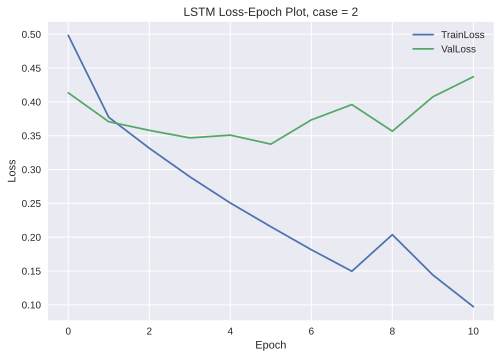

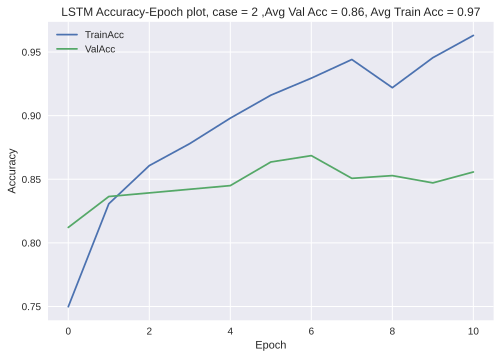

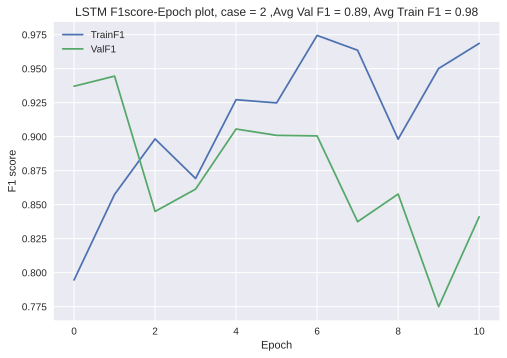

In [78]:
plotit_LSTM()

In [ ]:
plotit_RNN()

# Training with respect to hyperparameter tuning

In [ ]:
# Plot losses and accuracies for the training and validation sets.
def plotit_GRU():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 12))
    plt.subplot(2,2,1)
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GRU Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"GRU Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccGRUVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccGRUTrain[icase]):.2f}")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['train_f1'], label = "TrainF1")
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['val_f1'], label = "ValF1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 score")
    plt.title(f"GRU F1Score-Epoch plot, case = {icase + 1} ,Avg Val F1 = {np.mean(finalF1GRUVal[icase]):.2f}, Avg Train Acc = {np.mean(finalF1GRUTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccGRUVal[icase])}, Avg Train Accuracy = {np.mean(finalAccGRUTrain[icase])}")
    print(f"Average F1 score over multiple iterations, case = {icase + 1}, Avg Val F1 score = {np.mean(finalF1GRUVal[icase])}, Avg Train F1 score= {np.mean(finalF1GRUTrain[icase])}")

# Changing neural architecture

In [57]:

class RNNRepresentation2(nn.Module):

    def __init__(self, voc_size, emb_dim, rnn_size, icase):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.icase = icase

        # The RNN module: either a basic RNN, LSTM, or a GRU.
        if icase == 1:
          self.rnn = nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 2:
          self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 3:
          self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 4:
          self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=2, batch_first=True)
          # self.iL2 = emb_dim + rnn_size*2
          # self.rnn2 = nn.GRU(input_size=self.iL2, hidden_size=self.iL2, bidirectional=True, num_layers=1, batch_first=True)




    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)

        embedded = self.embedding(X)

        # Shape of embedded: (n_docs, n_words, emb_dim)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.

        if self.icase == 1 or self.icase == 3 or self.icase == 4:
          rnn_out, final_state = self.rnn(embedded)
          # input_layer2 = torch.cat((embedded,rnn_out),dim=2)
          # rnn_out, final_state = self.rnn2(input_layer2)
        elif self.icase == 2:
          # use the following instead if you're using an LSTM:
          rnn_out, (final_state, _) = self.rnn(embedded)

        # For a GRU or simple RNN, final_state is a single tensor
        # of the shape (n_layers, n_docs, 2*rnn_size)

        top_forward = final_state[-2]
        top_backward = final_state[-1]
        top_both = torch.cat([top_forward, top_backward], dim=1)

        return top_both

class TextClassifierParameters():
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 50

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-3

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-5

    # Dropout probability.
    dropout = 0.2

    # Word embedding dimensionality.
    emb_dim = 64

    # RNN size
    rnn_size = 128  # 128

In [58]:
def main_gru():

    # Read the data.
    X, Y = readData(filePath)

    print(f'Loaded {len(Y)} documents.')

    # Initialize the text classifier
    params = TextClassifierParameters()
    clf = TextClassifier(params)

    # Preprocess the data.
    clf.preprocess(X, Y, ngrams = None, flagNoStop = None)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.

    clf.set_model(nn.Sequential(
        RNNRepresentation2(voc_size=clf.voc_size, emb_dim=params.emb_dim,
                          rnn_size=params.rnn_size, icase = 4),
        nn.Dropout(params.dropout),
        nn.Linear(in_features=2 * params.rnn_size, out_features=clf.n_classes)
    ))

    # Train the classifier.
    clf.train()

    return clf

In [59]:
# GRU nlayers = 2
maxIter = 5
finalAccGRUVal = list()
finalAccGRUTrain = list()
finalF1GRUVal = list()
finalF1GRUTrain = list()
gru_classifier = list()
for icase in range(1):
  print("case ", icase + 1)
  gru_classifier.append(list())
  finalAccGRUVal.append(np.zeros(maxIter))  
  finalAccGRUTrain.append(np.zeros(maxIter))
  finalF1GRUVal.append(np.zeros(maxIter))
  finalF1GRUTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    gru_classifier[icase].append(main_gru())
    finalAccGRUVal[icase][iterations] = gru_classifier[icase][iterations].history['val_acc'][len(gru_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccGRUTrain[icase][iterations] = gru_classifier[icase][iterations].history['train_acc'][len(gru_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1GRUTrain[icase][iterations] = gru_classifier[icase][iterations].history['train_f1'][len(gru_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1GRUVal[icase][iterations] = gru_classifier[icase][iterations].history['val_f1'][len(gru_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccGRUVal[icase])}, Avg Train Accuracy = {np.mean(finalAccGRUTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1GRUVal[icase])}, Avg Train F1 = {np.mean(finalF1GRUTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.1634, train acc: 0.9359, val loss: 0.3185, val acc: 0.8714, time: 2.5294
Loaded 7000 documents.
Epoch 5: train loss: 0.1641, train acc: 0.9382, val loss: 0.3375, val acc: 0.8743, time: 2.4154
Loaded 7000 documents.
Epoch 5: train loss: 0.1590, train acc: 0.9391, val loss: 0.3048, val acc: 0.8700, time: 2.4038
Loaded 7000 documents.
Epoch 5: train loss: 0.1716, train acc: 0.9380, val loss: 0.3291, val acc: 0.8629, time: 2.4195
Loaded 7000 documents.
Epoch 5: train loss: 0.1572, train acc: 0.9425, val loss: 0.3395, val acc: 0.8600, time: 2.3955
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8642857142857142, Avg Train Accuracy = 0.9815357142857144
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.8902373601603095, Avg Train F1 = 0.9884765226509826


In [61]:
def main_gru_hidden():

    # Read the data.
    X, Y = readData(filePath)

    print(f'Loaded {len(Y)} documents.')

    # Initialize the text classifier
    params = TextClassifierParameters()
    clf = TextClassifier(params)

    # Preprocess the data.
    clf.preprocess(X, Y, ngrams = None, flagNoStop = None)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.

    clf.set_model(nn.Sequential(
        RNNRepresentation2(voc_size=clf.voc_size, emb_dim=params.emb_dim,
                          rnn_size=params.rnn_size, icase = 3),
        nn.Dropout(params.dropout),
        nn.Linear(in_features=2 * params.rnn_size, out_features=2 * params.rnn_size),
        nn.Linear(in_features=2 * params.rnn_size, out_features=clf.n_classes)
    ))

    # Train the classifier.
    clf.train()

    return clf

In [62]:
# GRU hidden layer
maxIter = 5
finalAccGRUHVal = list()
finalAccGRUHTrain = list()
finalF1GRUHVal = list()
finalF1GRUHTrain = list()
gruh_classifier = list()
for icase in range(1):
  print("case ", icase + 1)
  gruh_classifier.append(list())
  finalAccGRUHVal.append(np.zeros(maxIter))  
  finalAccGRUHTrain.append(np.zeros(maxIter))
  finalF1GRUHVal.append(np.zeros(maxIter))
  finalF1GRUHTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    gruh_classifier[icase].append(main_gru_hidden())
    finalAccGRUHVal[icase][iterations] = gruh_classifier[icase][iterations].history['val_acc'][len(gruh_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccGRUHTrain[icase][iterations] = gruh_classifier[icase][iterations].history['train_acc'][len(gruh_classifier[icase][iterations].history['train_acc']) - 1]
    finalF1GRUHTrain[icase][iterations] = gruh_classifier[icase][iterations].history['train_f1'][len(gruh_classifier[icase][iterations].history['train_f1']) - 1]
    finalF1GRUHVal[icase][iterations] = gruh_classifier[icase][iterations].history['val_f1'][len(gruh_classifier[icase][iterations].history['val_f1']) - 1]

  print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccGRUHVal[icase])}, Avg Train Accuracy = {np.mean(finalAccGRUHTrain[icase])}")
  print(f"Average F1 over multiple iterations, case = {icase + 1}, Avg Val F1 = {np.mean(finalF1GRUHVal[icase])}, Avg Train F1 = {np.mean(finalF1GRUHTrain[icase])}")

case  1
Loaded 7000 documents.
Epoch 5: train loss: 0.1543, train acc: 0.9409, val loss: 0.3081, val acc: 0.8750, time: 2.0235
Loaded 7000 documents.
Epoch 5: train loss: 0.1658, train acc: 0.9389, val loss: 0.3203, val acc: 0.8664, time: 2.0542
Loaded 7000 documents.
Epoch 5: train loss: 0.1674, train acc: 0.9350, val loss: 0.3755, val acc: 0.8621, time: 2.0394
Loaded 7000 documents.
Epoch 5: train loss: 0.1785, train acc: 0.9295, val loss: 0.3570, val acc: 0.8700, time: 2.0345
Loaded 7000 documents.
Epoch 5: train loss: 0.1855, train acc: 0.9287, val loss: 0.3714, val acc: 0.8507, time: 2.0724
Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.8598571428571429, Avg Train Accuracy = 0.9780714285714286
Average F1 over multiple iterations, case = 1, Avg Val F1 = 0.8628264465392437, Avg Train F1 = 0.9843524537695671


# Results and Inference from GRU models

The effect of embedding dimension is studied by only considering them fixed discrete values, specifically, embedding dimension is iterated over the set $\{32, 64, 128\}$. 5 iterations were performed for each of these cases. A randomly picked iteration is plotted. For each embedding dimension, training curve and accuracy plot is shown resulting in 6 plots. The average training and validation accuracies are mentioned on plot title(Right figures).

In [ ]:
plotit_GRU()

**Inferences GRU model**

The results depict that the for case with enbedding dimension $= 128$, the validation and test accuracies were slightly better than other two cases. Hence, the hyperparameter needs additional tuning to fix embedding dimension for this scenario. 

Case | Train Acc | Val Acc | Test Acc
---| --- | --- | --- 
32 | 0.78 | 0.58 | 0.59
64 | 0.69 | 0.57 | 0.58
128 | 0.74 | 0.60 | 0.60

Some top predictions made on individual sense by each case are shown here:

Case 32 | Case 64 | Case 128
--- | --- | ---
line.n = 0.88 | line.n = 0.88 | line.n = 0.89
keep.v = 0.73 | keep.v = 0.71 | see.v = 0.71
see.v = 0.73 | see.v = 0.70 | keep.v = 0.70
professional.a = 0.67 | professional.a = 0.67 | active.a = 0.69

It is also observed that the lemma's that gave poor performances e.g. "build", "lead" etc have wide range of word sense but smaller training data. Hence, the question of how large training is required stil holds. Lastly, it can be observed that as expected, the overall test accuracy has improved a lot in case of GRU as compared to any of the CBOW model. 

# Additional Consideration

The performances in RNN clearly motivated to have a large training dataset. One way to overcome this is to use pretrained word embeddings like BERT. The next document contains the BERT model. Final conclusions are also drafted in that file. File name - "WSD_BERT.ipynb".